In [ ]:
import h5py
import numpy as np
from sklearn.metrics import mean_absolute_error
import pandas as pd
from disaggregate.im2seq_clean import Im2Seq
from disaggregate.batchgenerator import BatchGenerator 
import matplotlib.pyplot as plt

In [2]:
def load_data_for_im2seq(h5_path, appliance, building='building2', max_ratio=0.3):
    with h5py.File(h5_path, 'r') as f:
        mains = f[f'{building}/mains/power/active'][:]
        target = f[f'{building}/{appliance}/power/active'][:]

    # Trim to same length
    min_len = min(len(mains), len(target))
    mains = mains[:min_len]
    target = target[:min_len]

    # Optionally truncate for quick testing
    if max_ratio < 1.0:
        trim_len = int(min_len * max_ratio)
        mains = mains[:trim_len]
        target = target[:trim_len]

    # Return as single-column DataFrames (expected by Im2Seq)
    return pd.DataFrame(mains, columns=['mains']), pd.DataFrame(target, columns=[appliance])

In [3]:

def inspect_h5_structure(filepath):
    with h5py.File(filepath, 'r') as f:
        def print_structure(name, obj):
            print(name)
        f.visititems(print_structure)

In [4]:
inspect_h5_structure('./data/REFIT_House2.h5')

building2
building2/dishwasher
building2/dishwasher/power
building2/dishwasher/power/active
building2/fridge_freezer
building2/fridge_freezer/power
building2/fridge_freezer/power/active
building2/hi_fi
building2/hi_fi/power
building2/hi_fi/power/active
building2/kettle
building2/kettle/power
building2/kettle/power/active
building2/mains
building2/mains/power
building2/mains/power/active
building2/microwave
building2/microwave/power
building2/microwave/power/active
building2/oven_extractor_fan
building2/oven_extractor_fan/power
building2/oven_extractor_fan/power/active
building2/television
building2/television/power
building2/television/power/active
building2/toaster
building2/toaster/power
building2/toaster/power/active
building2/washing_machine
building2/washing_machine/power
building2/washing_machine/power/active


In [5]:
# Load raw data
mains_df, appliance_df = load_data_for_im2seq('./data/REFIT_House2.h5', appliance='fridge_freezer', max_ratio=0.3)

# Downsample for fast training
mains_df = mains_df[:int(0.25 * len(mains_df))]
appliance_df = appliance_df[:int(0.25 * len(appliance_df))]


print(mains_df.shape, appliance_df.shape)

(430014, 1) (430014, 1)


In [6]:
print(mains_df.columns.tolist())

['mains']


In [7]:
print("Mains Data Range:")
print("  Min: ", mains_df['mains'].min())
print("  Max: ", mains_df['mains'].max())
print("  Mean:", mains_df['mains'].mean())
print("  Std: ", mains_df['mains'].std())

Mains Data Range:
  Min:  0.0
  Max:  13375.0
  Mean: 341.36893
  Std:  943.34357


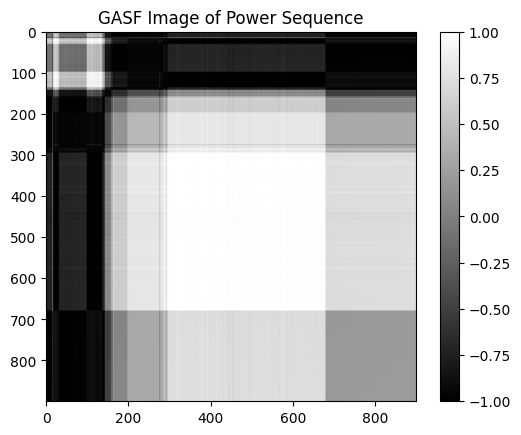

In [8]:
# Choose a short sequence (length must match model's expected input length)
sequence_length = 900
img_size = 900
example_seq = mains_df['mains'].values[:sequence_length].reshape(1, -1)  # shape (1, 200)

# Dummy target just to satisfy init (can be None)
dummy_target = np.zeros((1, sequence_length))

# Instantiate the generator for 1 sample
gen = BatchGenerator(
    x_sequence=example_seq,
    y_sequence=dummy_target,
    batch_size=1,
    img_method='gasf',  # or 'mtf', 'rp'
    img_size=img_size
)

# Get image and plot it
images, _ = gen.__getitem__(0)  # Returns one batch
plt.imshow(images[0].squeeze(), cmap='gray')
plt.title('GASF Image of Power Sequence')
plt.colorbar()
plt.show()

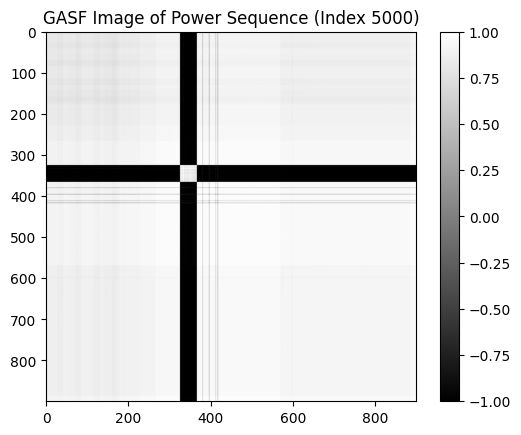

In [9]:
# Choose a new starting index and grab a new sequence
start_idx = 5000  # Change this to pick different time windows
sequence_length = 900
img_size = 900

example_seq = mains_df['mains'].values[start_idx:start_idx + sequence_length].reshape(1, -1)

# Dummy target (only needed because generator expects it)
dummy_target = np.zeros((1, sequence_length))

# Instantiate the generator
gen = BatchGenerator(
    x_sequence=example_seq,
    y_sequence=dummy_target,
    batch_size=1,
    img_method='gasf',  # or 'mtf', 'rp'
    img_size=img_size
)

# Generate and plot the image
images, _ = gen.__getitem__(0)
plt.imshow(images[0].squeeze(), cmap='gray', vmin=-1, vmax=1)
plt.title(f'GASF Image of Power Sequence (Index {start_idx})')
plt.colorbar()
plt.show()

In [ ]:
# Create and train model
model = Im2Seq({
    'sequence_length': 400,
    'img_size': 400,
    'img_method': 'gasf',         # 'mtf' 'gasf', 'rp'
    'n_epochs': 30,
    'batch_size': 100,
})

model.models['fridge'] = model.return_network()
model.appliance_params = {
    'fridge': {
        'mean': appliance_df['fridge_freezer'].mean(),
        'std': appliance_df['fridge_freezer'].std()
    }
}

model.partial_fit(
    [mains_df],                          # shape: (N, 1)
    [('fridge', [appliance_df])]         # shape: (N, 1)
)


# Use a chunk of data not used in training
X_test = mains_df[-10000:]               # shape: (1000, 1)
Y_test = appliance_df[-10000:]           # shape: (1000, 1)

Training Im2Seq model with method: gasf
train_main shape: (430015, 400), power shape: (430015, 400)
Training fridge...
Starting model.fit for fridge, epochs=30
Steps per epoch: 3655
Epoch 1/30
   6/3655 [..............................] - ETA: 2:55:58 - loss: 1.0019

In [ ]:
sequence_length = model.sequence_length
test_start = 200000
test_len = 20000

X_test = mains_df[test_start : test_start + test_len]
Y_test = appliance_df[test_start : test_start + test_len]

# Create input sequences
test_series = X_test.squeeze().values

print(f"mains_df.shape = {mains_df.shape}")
print(f"test_start = {test_start}, test_len = {test_len}")
print(f"Slice range: {test_start} to {test_start + test_len}")


if len(test_series) < sequence_length:
    raise ValueError(f"Test input too short (len={len(test_series)}), requires at least {sequence_length} points.")

test_sequences = np.array([
    test_series[i:i + sequence_length] 
    for i in range(len(test_series) - sequence_length + 1)
])
X_test_seq_df = pd.DataFrame(test_sequences)

# Predict
results = model.disaggregate_chunk([X_test_seq_df])
predicted = results[0]['fridge'].values

# Align true values to predicted
true_values = Y_test.squeeze().values[:len(predicted)]

# Compute MAE
mae = mean_absolute_error(true_values, predicted)
print("MAE:", mae)


In [ ]:
import matplotlib.pyplot as plt

start_idx = 5000        
end_idx = 10000      

plt.figure(figsize=(16, 5))
plt.plot(true_values[start_idx:end_idx], label='Ground Truth', alpha=0.8, linewidth=1.5)
plt.plot(predicted[start_idx:end_idx], label='Predicted', alpha=0.8, linewidth=1.5)

plt.title('NILM Appliance Disaggregation — Fridge')
plt.xlabel('Time Step')
plt.ylabel('Power (Watts)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
